In [1]:
# d6598 
# "I bet computers can't make music"
# - Felonious Gru

beat_resolution = 12 # Standard of 24 for full 34 and 44 representation.
                    # Dont go below 8 otherwise risk distortion. 12 is a safe spot to end up
bar_length = beat_resolution * 4
bars = 8
NOTES_PER_OCTAVE = 12
MIDI_INPUTS = 128  # Length the rolls pitches must be
MIDDLE_C = 64
num_notes_above_c = int(1.8 * NOTES_PER_OCTAVE)  # Centered around C, how many on either side
num_notes_below_c = int(2.5 * NOTES_PER_OCTAVE)
num_pitches = num_notes_above_c + num_notes_below_c
lookback = bar_length*4  # How far back can the model look? (Default to *4)
step = 1  # Skip through it a bit
tempo = 60  # Rough tempo of the samples. Only used for accurate timing of the output

%matplotlib inline
import os
from functions import Midi

# Load the functions dir
midi = Midi(middle_c=MIDDLE_C,
            midi_inputs=MIDI_INPUTS,
            num_notes_above_c=num_notes_above_c,
            num_notes_below_c=num_notes_below_c,
            beat_resolution=beat_resolution)


Found 36 files: ['1080-c12.mid', 'jsbwv552.mid', 'bwv539_2.mid', 'bwv582.mid', 'bwv539_1.mid', 'bwv525-1.mid', 'jsbwv541.mid', '1080-c01.mid', 'bwv525-2.mid', 'jsbwv543.mid', 'bwv525-3.mid', '1080-c02.mid', 'bwv1028.mid', 'bwv1029.mid', '1080c02b.mid', 'bwv537.mid', 'jsbwv533.mid', 'jsbwv532.mid', 'bwv686.mid', 'bwv653.mid', 'bwv733.mid', 'bwv552p.mid', 'bwv552f.mid', 'bwv1027.mid', 'bwv539.mid', 'bwv530-2.mid', 'bwv529-3.mid', 'bwv529-2.mid', 'bwv588.mid', 'bwv530-3.mid', 'bwv530-1.mid', 'bwv529-1.mid', 'goldberg.mid', 'jsbwv549.mid', 'bwv0541p.mid', 'bwv0541f.mid']
Lower bound 34.
Upper bound 85.
Num pitches 51
Refined midi files ['goldberg.mid']
goldberg.mid input shape: (76871, 128)
...Refined down 77 dimensions with 293 note loss.
...Loss of 0.17 %
...Output shape: (76871, 51)
extended output shape (76871, 51)
76679 individual phrases.


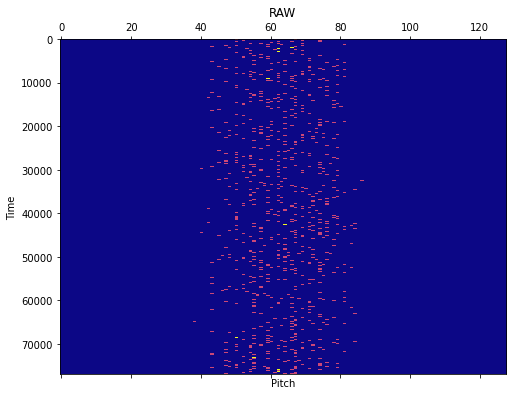

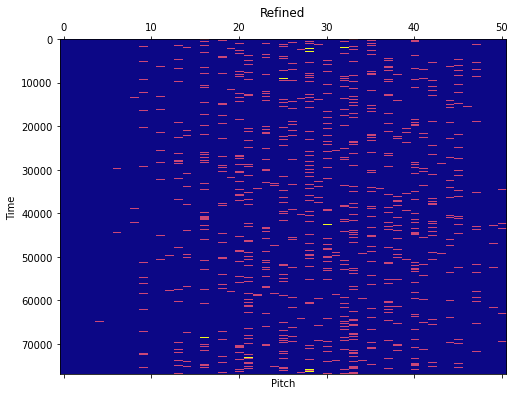

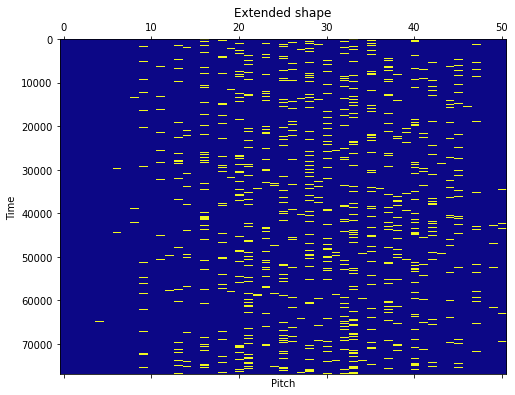

In [5]:
root = '/Users/James/PycharmProjects/deep-learning/music/lstm-generation-bach'
#root = '/home/ubuntu/deep-learning/music/lstm-generation-bach'
midi_dir = os.path.join(root, 'midi')
model_dir = os.path.join(root, 'models')

#midi.preview_data(midi_dir, 'bwv653.mid', beat_resolution=12)
extended = midi.load_midi(midi_dir, over_ride_fnames=['goldberg.mid'], display=True)
x, y = midi.vectorise(extended, lookback=lookback, step=step)

In [3]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.LSTM(256, input_shape=(lookback, num_pitches), return_sequences=True, dropout=0.1, recurrent_dropout=0.2))
model.add(layers.LSTM(128, dropout=0.1, recurrent_dropout=0.2, return_sequences=False))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_pitches, activation='sigmoid'))
model.summary()

model.compile(loss='categorical_crossentropy',  # categorical_crossentropy or mse
              optimizer=RMSprop(),
              metrics=['acc'])

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 192, 256)          315392    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 51)                3315      
Total params: 540,595
Trainable params: 540,595
Non-trainable params: 0
_________________________________________________________________


In [4]:
from time import time
first_start = time()
for i in range(10):
    print('>Epoch batch', i)
    start = time()
    history = model.fit(x, y,
                        epochs=10,
                        batch_size=512,
                        verbose=1)
    print('Took %s minutes.' % ((time()-start)/60).__round__(2))
    midi.save_model(model, model_dir, fname='lstm-v12.h5')
print('Full train took %s minutes.' % ((time()-first_start)/60).__round__(2))

>Epoch batch 0
Epoch 1/10
6725/6725 [==============================] - 9s 1ms/step - loss: 8.3182 - acc: 0.0819
Epoch 2/10
6725/6725 [==============================] - 8s 1ms/step - loss: 7.8683 - acc: 0.0300
Epoch 3/10
6725/6725 [==============================] - 8s 1ms/step - loss: 7.8052 - acc: 0.0165
Epoch 4/10
6725/6725 [==============================] - 8s 1ms/step - loss: 7.6546 - acc: 0.0242
Epoch 5/10
6725/6725 [==============================] - 8s 1ms/step - loss: 7.2539 - acc: 0.0424
Epoch 6/10
6725/6725 [==============================] - 8s 1ms/step - loss: 6.8296 - acc: 0.0773
Epoch 7/10
6725/6725 [==============================] - 8s 1ms/step - loss: 6.3674 - acc: 0.2497
Epoch 8/10
6725/6725 [==============================] - 8s 1ms/step - loss: 5.9537 - acc: 0.2993
Epoch 9/10
6725/6725 [==============================] - 8s 1ms/step - loss: 5.5945 - acc: 0.3303
Epoch 10/10
6725/6725 [==============================] - 8s 1ms/step - loss: 5.3538 - acc: 0.3472
Took 1.34 minu

6725/6725 [==============================] - 8s 1ms/step - loss: 2.8869 - acc: 0.4446
Took 1.3 minutes.
Saved model "lstm-v12.h5"
>Epoch batch 8
Epoch 1/10
6725/6725 [==============================] - 8s 1ms/step - loss: 2.8959 - acc: 0.4436
Epoch 2/10
6725/6725 [==============================] - 8s 1ms/step - loss: 2.8967 - acc: 0.4562
Epoch 3/10
6725/6725 [==============================] - 8s 1ms/step - loss: 2.8778 - acc: 0.4305
Epoch 4/10
6725/6725 [==============================] - 8s 1ms/step - loss: 2.8810 - acc: 0.4506
Epoch 5/10
6725/6725 [==============================] - 8s 1ms/step - loss: 2.8836 - acc: 0.4601
Epoch 6/10
6725/6725 [==============================] - 8s 1ms/step - loss: 2.8587 - acc: 0.4480
Epoch 7/10
6725/6725 [==============================] - 8s 1ms/step - loss: 2.8629 - acc: 0.4345
Epoch 8/10
6725/6725 [==============================] - 8s 1ms/step - loss: 2.8298 - acc: 0.4666
Epoch 9/10
6725/6725 [==============================] - 8s 1ms/step - loss: 2.8

In [6]:
from keras import models
model = midi.load_model(models, model_dir, fname='lstm-v6.h5')

Loaded model "lstm-v6.h5"


In [7]:
temps = [0.5, 0.55, 0.6, 0.7]
#temps = [0.6]  # Was best one
outputs = midi.generate(model, extended, temperatures=temps, lookback=lookback, length=8)

midi.smart_save(outputs, display=False, fname='potential-v6.mid')



Generating with seed index of 5076
Generating roll with temp 0.5 and length 768
Generating roll with temp 0.55 and length 768
Generating roll with temp 0.6 and length 768
Generating roll with temp 0.7 and length 768
Saving 4 tracks in one file "potential-v6.mid".
Saved file "potential-v6.mid".


/Users/james/PycharmProjects/deep-learning/music/lstm-generation-bach/functions.py:140: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds) / temperature
